Training Model... (This may take 1-2 minutes)
Epoch 1/25


/Users/aryangahlot/.pyenv/versions/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0072
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010   
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010    
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 8/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 9/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 10/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 11/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010    
Epoch 12/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 13/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 14/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 15/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s

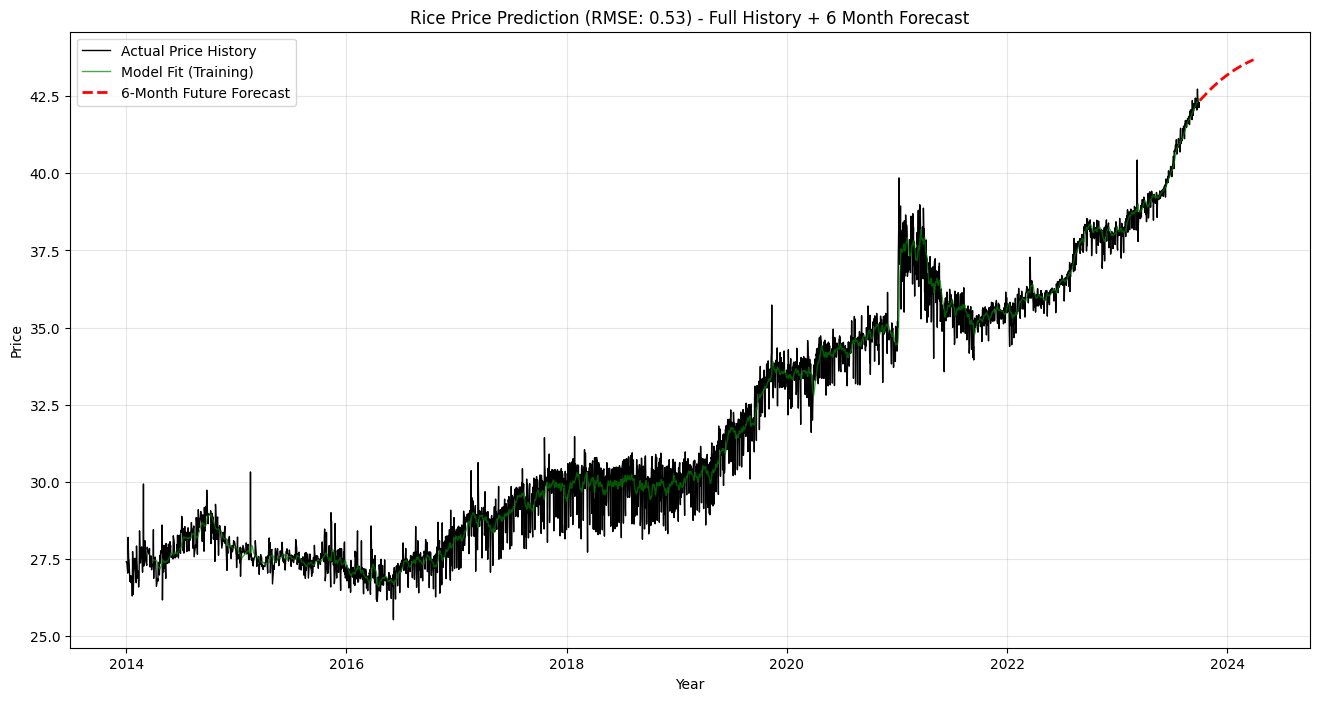


First 5 Days of Future Forecast:
[[42.37185872]
 [42.37217141]
 [42.37716516]
 [42.38475266]
 [42.39377032]]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math

# 1. Load and Process Data
file_path = 'Grains/Rice.csv'  # Verify your file path
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# 2. Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))

# 3. Create Sequences
prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 4. Build and Train LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
print("Training Model... (This may take 1-2 minutes)")
model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=1)

# 5. Predict on the ENTIRE Dataset (to see history match)
# We use the whole dataset to generate a prediction line that covers years
all_inputs = df['value'].values.reshape(-1, 1)
all_inputs_scaled = scaler.transform(all_inputs)

x_all = []
# We can only predict starting from 'prediction_days' index
for x in range(prediction_days, len(all_inputs_scaled)):
    x_all.append(all_inputs_scaled[x-prediction_days:x, 0])

x_all = np.array(x_all)
x_all = np.reshape(x_all, (x_all.shape[0], x_all.shape[1], 1))

predicted_all = model.predict(x_all)
predicted_all = scaler.inverse_transform(predicted_all)

# Calculate RMSE on the whole dataset
real_values = df['value'].iloc[prediction_days:].values
rmse = math.sqrt(mean_squared_error(real_values, predicted_all))
print(f"\nModel Performance (RMSE): {rmse:.2f}")

# 6. Forecast Future (Next 6 Months / 180 Days)
future_days = 180
future_predictions = []
# Start with the last known 60 days
last_60_days = all_inputs_scaled[-prediction_days:]
current_batch = last_60_days.reshape(1, prediction_days, 1)

for i in range(future_days):
    # Predict next price (scaled)
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    
    # Update batch: remove first day, add new prediction
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(future_predictions)

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

# 7. Plotting: All History + Future
plt.figure(figsize=(16, 8))

# Plot Actual History
plt.plot(df.index, df['value'], label='Actual Price History', color='black', linewidth=1)

# Plot Model's "Training" Predictions (How well it learned)
# We need to align the index (shift by prediction_days)
train_plot_index = df.index[prediction_days:]
plt.plot(train_plot_index, predicted_all, label='Model Fit (Training)', color='green', linewidth=1, alpha=0.7)

# Plot Future Forecast
plt.plot(future_dates, future_predictions, label='6-Month Future Forecast', color='red', linestyle='--', linewidth=2)

plt.title(f'Rice Price Prediction (RMSE: {rmse:.2f}) - Full History + 6 Month Forecast')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nFirst 5 Days of Future Forecast:")
print(future_predictions[:5])

Training Model on 2014-2020 data...
Epoch 1/25


/Users/aryangahlot/.pyenv/versions/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0138
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 9/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027
Epoch 10/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029
Epoch 11/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 12/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 13/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029
Epoch 14/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 15/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0028
Epoch 16/25
72/

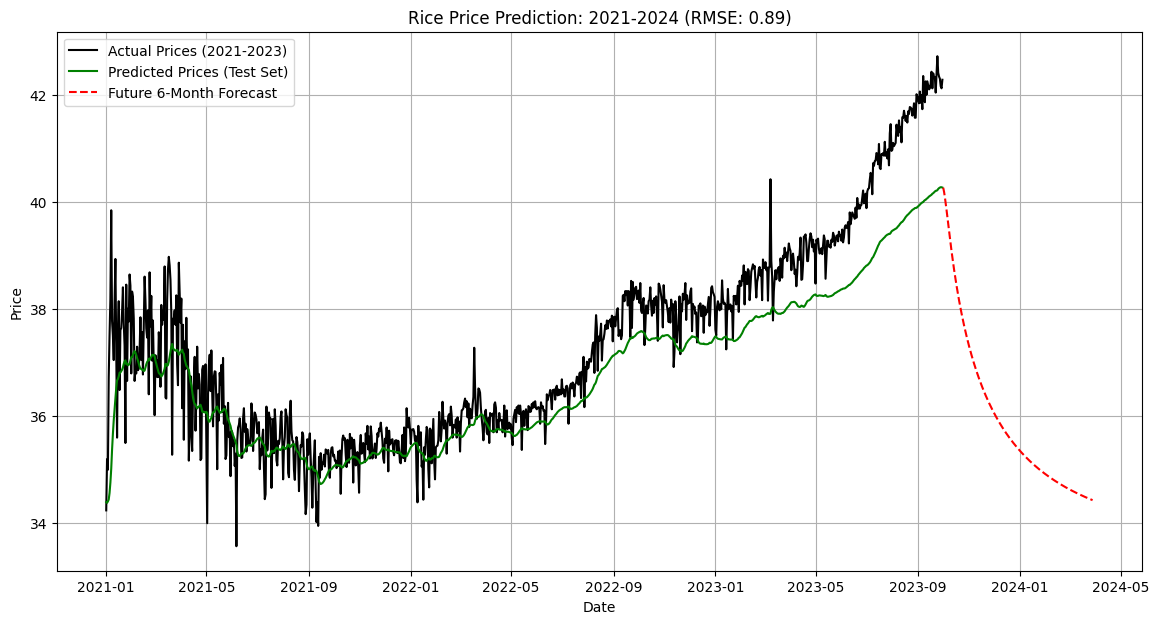

Root Mean Squared Error (RMSE) on Test Data: 0.89

First 5 days of future forecast:
[[40.27239792]
 [40.19628289]
 [40.0957861 ]
 [39.9795108 ]
 [39.85380254]]


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math

# 1. Load Data
file_path = 'Grains/Rice.csv' 
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out the extreme outliers
df_cleaned = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

# 2. Split into Train (2014-2020) and Test (2021-End)
train_data = df_cleaned[:'2020-12-31']
test_data = df_cleaned['2021-01-01':]

# 3. Scale the Data
# Important: Fit scaler ONLY on training data to prevent data leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data.values)

# 4. Prepare Training Data
prediction_days = 60
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_train)):
    x_train.append(scaled_train[x-prediction_days:x, 0])
    y_train.append(scaled_train[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# 5. Build and Train Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
print("Training Model on 2014-2020 data...")
model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=1)

# 6. Prepare Test Data
# To predict Jan 1, 2021, we need the last 60 days of 2020
# Combine total dataset to get the inputs
dataset_total = pd.concat((train_data['value'], test_data['value']), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_data) - prediction_days:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs) # Use the same scaler fitted on train data

x_test = []
for x in range(prediction_days, len(inputs)):
    x_test.append(inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# 7. Calculate RMSE for the Test Period
rmse = math.sqrt(mean_squared_error(test_data['value'].values, predicted_prices))

# 8. Future Forecast (Next 6 Months)
future_days = 180
future_predictions = []
# Start with the last 60 days of the KNOWN data (end of test set)
last_60_days = inputs[-prediction_days:]
current_batch = last_60_days.reshape(1, prediction_days, 1)

for i in range(future_days):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

future_predictions = scaler.inverse_transform(future_predictions)
future_dates = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=future_days)

# 9. Plotting
plt.figure(figsize=(14, 7))

# Plot Actual Test Data (2021-2023)
plt.plot(test_data.index, test_data['value'], color='black', label=f"Actual Prices (2021-{test_data.index[-1].year})")

# Plot Predicted Test Data
plt.plot(test_data.index, predicted_prices, color='green', label="Predicted Prices (Test Set)")

# Plot Future Predictions
plt.plot(future_dates, future_predictions, color='red', linestyle='--', label="Future 6-Month Forecast")

plt.title(f"Rice Price Prediction: 2021-2024 (RMSE: {rmse:.2f})")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.2f}")
print("\nFirst 5 days of future forecast:")
print(future_predictions[:5])

Training Data: 2702 days
Test Data: 638 days

--- Preparing Data for LSTM ---
Training Model... (This might take a minute)
Epoch 1/25


/Users/aryangahlot/.pyenv/versions/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0103
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 9/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 10/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019
Epoch 11/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 12/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 13/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 14/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 15/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 16/25
83/

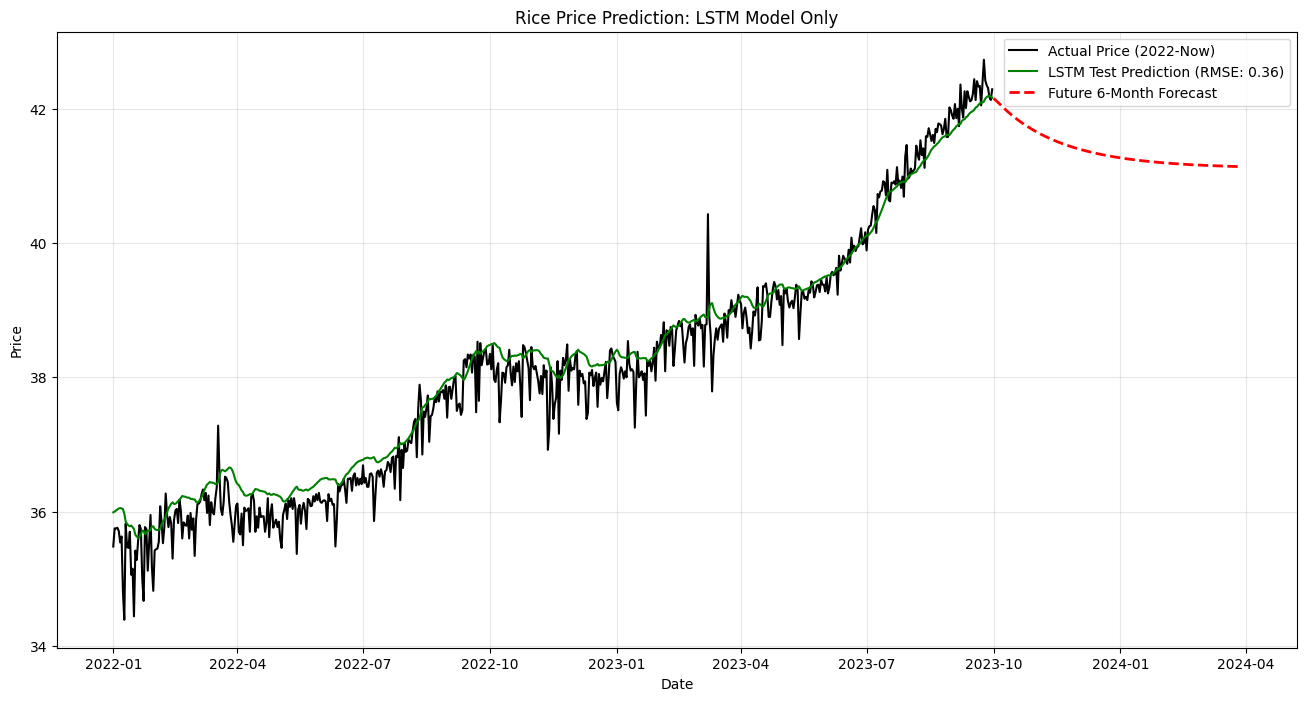


Next 5 Days Forecast:
2023-10-01    42.154481
2023-10-02    42.137048
2023-10-03    42.118144
2023-10-04    42.098319
2023-10-05    42.078140
Freq: D, dtype: float64


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import math

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================
file_path = 'Grains/Rice.csv'  # Verify your file path matches exactly
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# Define Split Dates
train_end_date = '2021-12-31'
test_start_date = '2022-01-01'

# Split Data
train_data = df[:train_end_date]
test_data = df[test_start_date:]

print(f"Training Data: {len(train_data)} days")
print(f"Test Data: {len(test_data)} days")

# ==========================================
# 2. PREPARE DATA (SCALING)
# ==========================================
print("\n--- Preparing Data for LSTM ---")
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit scaler ONLY on training data to avoid leakage
scaled_train = scaler.fit_transform(train_data.values)

prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_train)):
    x_train.append(scaled_train[x-prediction_days:x, 0])
    y_train.append(scaled_train[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# ==========================================
# 3. BUILD & TRAIN LSTM MODEL
# ==========================================
model = Sequential()
# Layer 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Layer 2
model.add(LSTM(units=50, return_sequences=False))
# Dense Layers
model.add(Dense(units=25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

print("Training Model... (This might take a minute)")
model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=1)

# ==========================================
# 4. PREDICT TEST SET (2022-2024)
# ==========================================
# We need the last 60 days of the training set to start predicting the test set
dataset_total = pd.concat((train_data['value'], test_data['value']), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_data) - prediction_days:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for x in range(prediction_days, len(inputs)):
    x_test.append(inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Create a Series for plotting alignment
test_predictions_series = pd.Series(predicted_prices.flatten(), index=test_data.index)

# ==========================================
# 5. FORECAST FUTURE (NEXT 6 MONTHS)
# ==========================================
future_days = 180
future_predictions = []

# Start with the very last 60 days of known data
last_60_days = inputs[-prediction_days:]
current_batch = last_60_days.reshape(1, prediction_days, 1)

for i in range(future_days):
    # Predict 1 day ahead
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    
    # Update batch: remove first item, add new prediction to the end
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverse transform to get real prices
future_predictions = scaler.inverse_transform(future_predictions)

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
future_series = pd.Series(future_predictions.flatten(), index=future_dates)

# ==========================================
# 6. EVALUATION & PLOTTING
# ==========================================
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(test_data['value'], predicted_prices))
print(f"\nLSTM Model Accuracy (RMSE): {rmse:.2f}")

plt.figure(figsize=(16, 8))

# Plot 1: Actual Prices (Test Period)
plt.plot(test_data.index, test_data['value'], label='Actual Price (2022-Now)', color='black', linewidth=1.5)

# Plot 2: LSTM Test Predictions
plt.plot(test_predictions_series.index, test_predictions_series, label=f'LSTM Test Prediction (RMSE: {rmse:.2f})', color='green', linewidth=1.5)

# Plot 3: Future Forecast
plt.plot(future_series.index, future_series, label='Future 6-Month Forecast', color='red', linestyle='--', linewidth=2)

plt.title('Rice Price Prediction: LSTM Model Only')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nNext 5 Days Forecast:")
print(future_series.head(5))

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib  # For saving the scaler
import math

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Root folder where your CSVs are stored
dataset_root = 'Price_Dataset' 
# Folder to save models and scalers
models_dir = 'models'
# Folder to save prediction graphs (optional, but good for checking)
graphs_dir = 'graphs'

os.makedirs(models_dir, exist_ok=True)
os.makedirs(graphs_dir, exist_ok=True)

# Training parameters
train_end_date = '2021-12-31'
test_start_date = '2022-01-01'
prediction_days = 60
future_days = 180
epochs = 15  # Reduced slightly for speed in batch mode
batch_size = 32

# ==========================================
# 2. FIND ALL CSV FILES
# ==========================================
# This recursively finds all .csv files inside Price_Dataset
csv_files = glob.glob(f"**/*.csv", recursive=True)
print(f"Found {len(csv_files)} datasets to process.")

# ==========================================
# 3. BATCH TRAINING LOOP
# ==========================================
for file_path in csv_files:
    try:
        # Extract commodity name from filename (e.g., 'Rice' from 'Rice.csv')
        filename = os.path.basename(file_path)
        commodity_name = os.path.splitext(filename)[0]
        
        # Sanitize name for saving (replace spaces with underscores)
        safe_name = commodity_name.replace(" ", "_").replace("/", "-")
        
        print(f"\n--- Processing: {commodity_name} ---")
        
        # Load Data
        df = pd.read_csv(file_path)
        
        # Check if required columns exist (handling different potential column names)
        if 'date' not in df.columns or 'value' not in df.columns:
            print(f"Skipping {filename}: Missing 'date' or 'value' columns.")
            continue
            
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').set_index('date')
        
        # Handle missing data (Forward Fill)
        df = df.asfreq('D', method='ffill')
        df = df.dropna()

        # Split Data
        train_data = df[:train_end_date]
        test_data = df[test_start_date:]
        
        if len(train_data) < prediction_days + 10:
            print(f"Skipping {filename}: Not enough training data.")
            continue

        # --- Scaling ---
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train = scaler.fit_transform(train_data.values)
        
        # Save the Scaler
        scaler_filename = os.path.join(models_dir, f"{safe_name}_scaler.pkl")
        joblib.dump(scaler, scaler_filename)

        # --- Prepare Training Data ---
        x_train, y_train = [], []
        for x in range(prediction_days, len(scaled_train)):
            x_train.append(scaled_train[x-prediction_days:x, 0])
            y_train.append(scaled_train[x, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # --- Build LSTM ---
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dense(units=25))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Save the Model
        model_filename = os.path.join(models_dir, f"{safe_name}_model.keras")
        model.save(model_filename)
        
        print(f"Model saved to: {model_filename}")

        # --- PREDICT & EVALUATE (For Verification) ---
        dataset_total = pd.concat((train_data['value'], test_data['value']), axis=0)
        inputs = dataset_total[len(dataset_total) - len(test_data) - prediction_days:].values
        inputs = inputs.reshape(-1, 1)
        inputs = scaler.transform(inputs)

        x_test = []
        for x in range(prediction_days, len(inputs)):
            x_test.append(inputs[x-prediction_days:x, 0])

        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        predicted_prices = model.predict(x_test)
        predicted_prices = scaler.inverse_transform(predicted_prices)
        
        # RMSE
        if len(test_data) > 0:
            rmse = math.sqrt(mean_squared_error(test_data['value'], predicted_prices))
            print(f"RMSE: {rmse:.2f}")
        
        # --- Future Forecast ---
        future_predictions = []
        last_60_days = inputs[-prediction_days:]
        current_batch = last_60_days.reshape(1, prediction_days, 1)

        for i in range(future_days):
            current_pred = model.predict(current_batch)[0]
            future_predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        future_predictions = scaler.inverse_transform(future_predictions)
        future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days)

        # --- Plot & Save Graph ---
        plt.figure(figsize=(10, 5))
        plt.plot(test_data.index, test_data['value'], color='black', label="Actual Price")
        plt.plot(test_data.index, predicted_prices, color='green', label="Predicted (Test)")
        plt.plot(future_dates, future_predictions, color='red', linestyle='--', label="Future 6 Months")
        plt.title(f"{commodity_name} Prediction")
        plt.legend()
        plt.grid(True)
        
        graph_filename = os.path.join(graphs_dir, f"{safe_name}_forecast.png")
        plt.savefig(graph_filename)
        plt.close() # Close plot to save memory
        print(f"Graph saved to: {graph_filename}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("\n✅ All datasets processed successfully!")

Found 22 datasets to process.

--- Processing: Daily Retail Price of Onion in All Centres, All Zones_1764046936 ---


/Users/aryangahlot/.pyenv/versions/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model saved to: models/Daily_Retail_Price_of_Onion_in_All_Centres,_All_Zones_1764046936_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━

/Users/aryangahlot/.pyenv/versions/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model saved to: models/Daily_Retail_Price_of_Tomato_in_All_Centres,_All_Zones_1764046936_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 2.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━

/Users/aryangahlot/.pyenv/versions/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
